In [27]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import re

In [28]:
info_df = pd.read_csv('./jeju_csv/information.csv', on_bad_lines='skip')
rev_df = pd.read_csv('./jeju_csv/review.csv', on_bad_lines='skip')
tour_df = pd.read_csv('./jeju_csv/tour.csv', on_bad_lines='skip')


print(info_df.columns.tolist())
print(rev_df.columns.tolist())
print(tour_df.columns.tolist())


['id', 'placeID', 'MCT_NM', 'MCT_NAVER_NAME', 'UE_CNT_GRP', 'UE_AMT_GRP', 'MON_UE_CNT_RAT', 'TUE_UE_CNT_RAT', 'WED_UE_CNT_RAT', 'THU_UE_CNT_RAT', 'FRI_UE_CNT_RAT', 'SAT_UE_CNT_RAT', 'SUN_UE_CNT_RAT', 'OP_YMD', 'HR_5_11_UE_CNT_RAT', 'HR_12_13_UE_CNT_RAT', 'HR_14_17_UE_CNT_RAT', 'HR_18_22_UE_CNT_RAT', 'HR_23_4_UE_CNT_RAT', 'UE_AMT_PER_TRSN_GRP', 'LOCAL_UE_CNT_RAT', 'RC_M12_MAL_CUS_CNT_RAT', 'RC_M12_FME_CUS_CNT_RAT', 'RC_M12_AGE_UND_20_CUS_CNT_RAT', 'RC_M12_AGE_30_CUS_CNT_RAT', 'RC_M12_AGE_40_CUS_CNT_RAT', 'RC_M12_AGE_50_CUS_CNT_RAT', 'RC_M12_AGE_OVR_60_CUS_CNT_RAT', 'MCT_TYPE', 'MCT_NAVER_TYPE', 'ADDR', 'WT', 'EWT', 'CD', 'NAVER_ADDR', 'PHONE', 'AMENITY', 'PAYMENT', 'TOTAL_REVIEW_NUM', 'TOTAL_BLOG_REVIEW_NUM', 'BOSS_TIP', 'AUTH_TITLE', 'crawling_main_ver', 'crawling_info_ver', 'crawling_review_ver', 'crawling_menu_ver', 'AUTH_CONTENT', 'keywords', 'keywords_embeddings', 'original_type', 'wheelchair_access', 'Closed', 'Latitude', 'Longitude']
['review_id', 'id', 'placeID', 'user_name', 'p

### 날짜 전처리

OP_YMD의 경우, `2021-12-09`, `20090217`와 같은 형태가 섞여있음.

모두 yyyy-mm-dd형식으로 수정. 후, `OP_YEAR`, `OP_MONTH`, `OP_DAY`, `OP_WEEKDAY`로 나눔. (weekday를 추가한 이유 확인 필요.)


In [29]:
def extract_date(x):
    try:
        if pd.isnull(x):
            return pd.NaT

        # 문자열 변환 후 숫자만 추출
        x_str = re.sub(r'\D', '', str(x))  # 숫자만 남기기

        if len(x_str) >= 8:
            y, m, d = x_str[:4], x_str[4:6], x_str[6:8]
            date_str = f"{y}-{m}-{d}"
            return pd.to_datetime(date_str, errors='coerce')
        else:
            return pd.NaT
    except:
        return pd.NaT
    

# OP_YMD 열 전처리
info_df['OP_YMD_CLEAN'] = info_df['OP_YMD'].apply(extract_date)

# 결과 확인
print(info_df['OP_YMD_CLEAN'].head())
print(info_df['OP_YMD_CLEAN'].dtype)  # datetime64[ns]

print(info_df['OP_YMD_CLEAN'].isna().sum())  # NaT 개수 확인

info_df['OP_YEAR'] = info_df['OP_YMD_CLEAN'].dt.year
info_df['OP_MONTH'] = info_df['OP_YMD_CLEAN'].dt.month
info_df['OP_DAY'] = info_df['OP_YMD_CLEAN'].dt.day
info_df['OP_WEEKDAY'] = info_df['OP_YMD_CLEAN'].dt.weekday  # 월:0 ~ 일:6

0   2015-03-27
1   2009-02-17
2   2021-12-09
3   2014-01-10
4   2023-11-29
Name: OP_YMD_CLEAN, dtype: datetime64[ns]
datetime64[ns]
0


### 순위? 인코딩

UE*CNT_GRP와 UE_AMT_GRP, UE_AMT_PER_TRSN_GRP_NUM는 `1*상위 10% 이하`, `2_10~25%`, `3_25~50%`, `4_50~75%`, `5_75~90%`, `6_90% 초과`와 같은 값을 가짐.
ordinal하기에 1부터 6까지의 정수로 인코딩


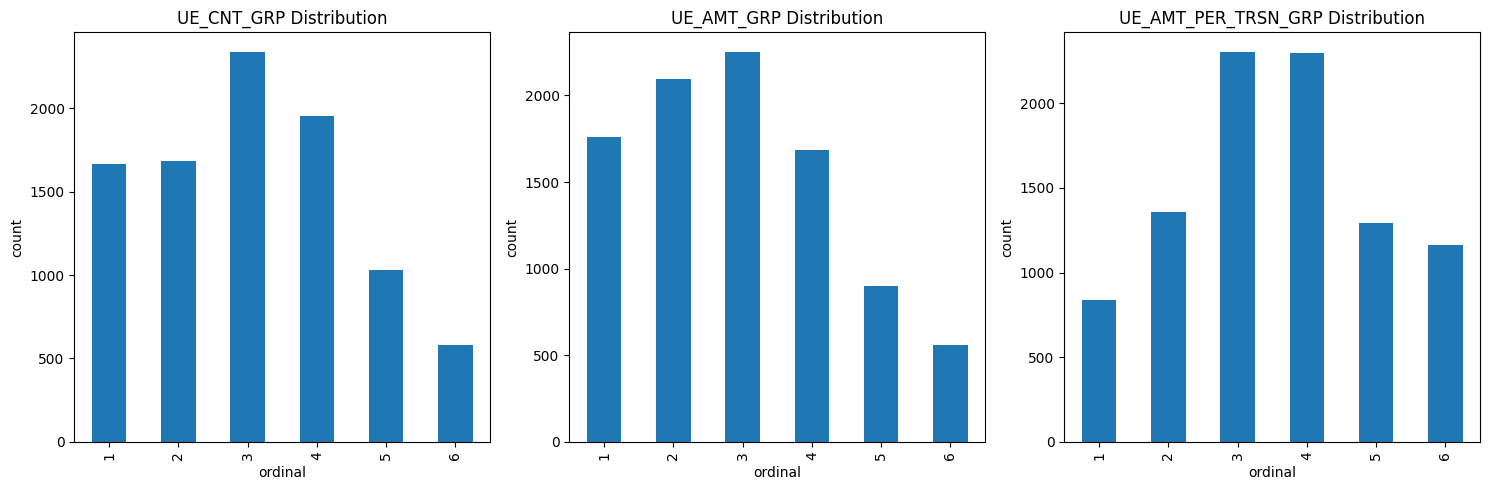

In [30]:
mapping_ordinal = {
    '1_상위 10% 이하': 1,
    '2_10~25%': 2,
    '3_25~50%': 3,
    '4_50~75%': 4,
    '5_75~90%': 5,
    '6_90% 초과': 6,
}

info_df['UE_CNT_GRP'] = info_df['UE_CNT_GRP'].map(mapping_ordinal)
info_df['UE_AMT_GRP'] = info_df['UE_AMT_GRP'].map(mapping_ordinal)
info_df['UE_AMT_PER_TRSN_GRP'] = info_df['UE_AMT_PER_TRSN_GRP'].map(mapping_ordinal)

plt.figure(figsize=(15, 5))

plt.subplot(131)
info_df['UE_CNT_GRP'].value_counts().sort_index().plot(kind='bar')
plt.title('UE_CNT_GRP Distribution')
plt.xlabel('ordinal')
plt.ylabel('count')

plt.subplot(132)
info_df['UE_AMT_GRP'].value_counts().sort_index().plot(kind='bar')
plt.title('UE_AMT_GRP Distribution')
plt.xlabel('ordinal')
plt.ylabel('count')

plt.subplot(133)
info_df['UE_AMT_PER_TRSN_GRP'].value_counts().sort_index().plot(kind='bar')
plt.title('UE_AMT_PER_TRSN_GRP Distribution')
plt.xlabel('ordinal')
plt.ylabel('count')

plt.tight_layout()
plt.show()


### 불필요한 feature 제거


In [31]:
# 제거할 컬럼 리스트
columns_to_drop = ['TOTAL_REVIEW_NUM', 'TOTAL_BLOG_REVIEW_NUM', 'EWT', 'CD', 'NAVER_ADDR', 'crawling_main_ver', 'crawling_info_ver', 'crawling_review_ver', 'crawling_menu_ver']

# 해당 컬럼 제거
info_df = info_df.drop(columns=columns_to_drop)

In [32]:
info_df.head().T

,0,1,2,3,4
id,1,2,3,4,5
placeID,NaN,1418972938.0,NaN,1463424775.0,1247912686.0
MCT_NM,(사)한국수상레저안전협회 제주제주시지부,(유)아웃백스테이크하우스 제주아일랜드점,(유)케이디에셋 담앤루,(주) 베이힐,(주) 비케이알 버거킹 제주화북DT점
MCT_NAVER_NAME,NaN,아웃백스테이크하우스 제주아일랜드점,NaN,베이힐풀앤빌라,버거킹 제주화북DT점
UE_CNT_GRP,1,6,4,2,6
UE_AMT_GRP,1,6,1,5,5
MON_UE_CNT_RAT,1.0,0.188065,0.214286,0.086957,0.115321
TUE_UE_CNT_RAT,0.0,0.083183,0.204082,0.086957,0.125206
WED_UE_CNT_RAT,0.0,0.108499,0.030612,0.26087,0.146623
THU_UE_CNT_RAT,0.0,0.083183,0.0,0.043478,0.14827


### 전처리 된 파일 저장


In [33]:
info_df.to_csv('./jeju_csv/info_df_processed.csv', index=False, encoding='utf-8')
print("good!")

good!
